# Load old simulation data

In [2]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [5]:
from typing import Tuple, Callable
import os
import shutil
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sithom.plot import plot_defaults, label_subplots
from sithom.time import timeit
from sithom.place import Point
from sithom.misc import in_notebook
from src.constants import DATA_PATH, FIGURE_PATH
from src.models.generation import ImpactSymmetricTC, Holland08
from src.conversions import si_ify, knots_to_ms
from src.constants import NEW_ORLEANS, DATA_PATH, NO_BBOX

In [4]:
paths = [
    "emulation_angle_pos_matern32_variance",
    "emulation_angle_pos_matern32_ent",
    "emulation_angle_pos_Mattern32",
    "emulation_angle_pos_Mattern52",
    "emulation_angle_pos_big",
]

In [11]:
os.listdir(os.path.join(DATA_PATH, "emulation_angle_pos_big"))

['61',
 '95',
 '59',
 '92',
 '66',
 '104',
 '50',
 '68',
 '103',
 '57',
 '32',
 '35',
 '102',
 '69',
 '56',
 '105',
 '51',
 '58',
 '67',
 '93',
 '94',
 '60',
 '34',
 '33',
 'data.nc',
 '20',
 '18',
 '27',
 '9',
 '0',
 '11',
 '7',
 '29',
 '16',
 '129',
 '42',
 '89',
 '116',
 '45',
 '111',
 '73',
 '118',
 '87',
 '127',
 '80',
 '74',
 '120',
 '6',
 '28',
 '17',
 '1',
 '10',
 '19',
 '26',
 '8',
 '21',
 '75',
 '81',
 '121',
 '119',
 '86',
 '72',
 '126',
 '44',
 '110',
 '43',
 '128',
 '88',
 '117',
 '38',
 '36',
 '31',
 '91',
 '65',
 '62',
 '96',
 '109',
 '100',
 '54',
 '107',
 '98',
 '53',
 '30',
 '37',
 '39',
 '106',
 '99',
 '52',
 '101',
 '55',
 '97',
 '108',
 '63',
 '64',
 '90',
 '46',
 '79',
 '112',
 '41',
 '115',
 '83',
 '77',
 '123',
 '48',
 '70',
 '84',
 '124',
 '24',
 '23',
 '4',
 '15',
 '3',
 '12',
 '85',
 '71',
 '125',
 '76',
 '82',
 '49',
 '122',
 '40',
 '114',
 '47',
 '113',
 '78',
 '2',
 '13',
 '5',
 '14',
 '22',
 '25']

In [18]:
ds_list = []
for path in paths:
    file_name = os.path.join(DATA_PATH, path, "data.nc")
    path_exists = os.path.exists(file_name)
    if path_exists:
        ds = xr.open_dataset(file_name)
        ds_list.append(ds[["init_x", "init_y"]])
ds_comb = xr.concat(ds_list, dim="inum")
ds_comb

<xarray.Dataset>
Dimensions:  (inum: 600, var: 2)
Coordinates:
  * var      (var) object 'x1' 'x2'
Dimensions without coordinates: inum
Data variables:
    init_x   (inum, var) float32 8.55 2.849 -22.95 -1.519 ... 1.458 -56.7 -1.506
    init_y   (inum) float64 0.8873 2.101 3.554 3.479 ... 6.26 0.628 1.329 4.091
Attributes:
    description:  Training Data

Text(0, 0.5, 'Position [$^{\\circ}$E]')

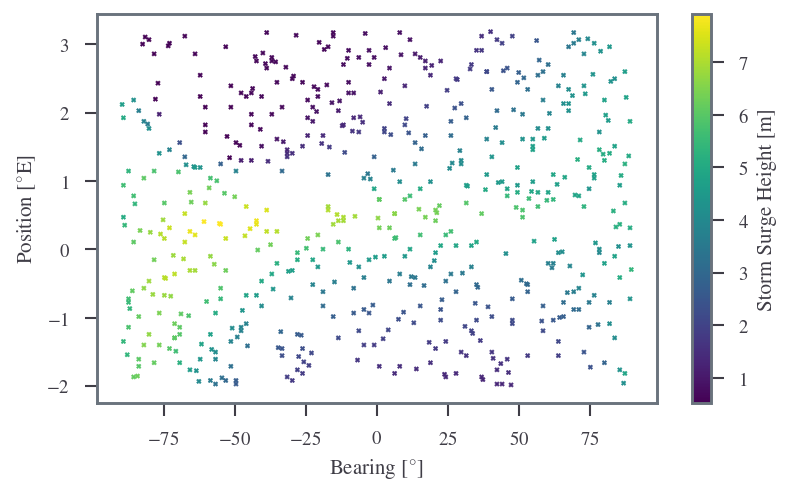

In [28]:
plot_defaults()
plt.scatter(ds_comb["init_x"].isel(var=0).values, ds_comb["init_x"].isel(var=1).values, s=5, c=ds_comb["init_y"].values)
plt.colorbar(label="Storm Surge Height [m]")
plt.xlabel("Bearing [$^{\circ}$]")
plt.ylabel("Position [$^{\circ}$E]")

In [10]:
os.listdir(os.path.join(DATA_PATH))

['sea_surface_temperature.nc',
 'mult3.25',
 'exp_h80',
 'kat_emulation',
 'katex-0.nc',
 'emulation_angle_pos_matern32_variance',
 'kat_xn',
 'katrina-0.nc',
 'mean_sea_level_pressure.nc',
 'kat_rmax',
 'katrina_water_era5.nc',
 'mult0.5',
 'fort.224.nc',
 'significant_height_of_combined_wind_waves_and_swell.nc',
 'emu_ex',
 'katrina_example_input.nc',
 '.DS_Store',
 'mult2.25',
 'emulation_angle_pos_poi',
 'fort.221.nc',
 'IBTrACS.ALL.v04r00.nc',
 'katrina-1.nc',
 'katrina_tides.nc',
 'katex.fort.221',
 'katrina_era5.nc',
 'emulation_angle_pos_mves',
 'katd_h08',
 'lhc',
 'mult1.75',
 'mult1',
 'emu2_ex',
 'mult3.5',
 'kate_h08',
 'mult0.75',
 'fort.218',
 'emu3_ex',
 'kat_pc',
 'kat_angle',
 '10m_v_component_of_wind.nc',
 'emu_angle_position',
 'total_precipitation.nc',
 'fort.221',
 'emulation_angle_pos_Mattern52',
 'fort.217',
 'emulation_angle_pos_big',
 'mult3.75',
 'README.md',
 'IBTrACS_gom_landings.nc',
 '2m_temperature.nc',
 'fort.218.nc',
 'mean_wave_period.nc',
 '10m_u_com

In [32]:
ds_comb["init_y"].max(dim="inum")

<xarray.DataArray 'init_y' ()>
array(7.91581181)

In [33]:
ds_list = []
for path in paths:
    file_name = os.path.join(DATA_PATH, path, "data.nc")
    path_exists = os.path.exists(file_name)
    if path_exists:
        ds = xr.open_dataset(file_name)
        ds_list.append(ds[["active_x", "active_y"]])
ds_act = xr.concat(ds_list, dim="anum")
ds_act

<xarray.Dataset>
Dimensions:   (anum: 190, var: 2)
Coordinates:
  * var       (var) object 'x1' 'x2'
Dimensions without coordinates: anum
Data variables:
    active_x  (anum, var) float64 90.0 3.2 -57.04 3.2 ... -0.1284 -82.82 -0.223
    active_y  (anum) float64 4.272 0.5898 4.822 1.288 ... 5.153 4.085 5.954
Attributes:
    description:  Training Data

Text(0, 0.5, 'Position [$^{\\circ}$E]')

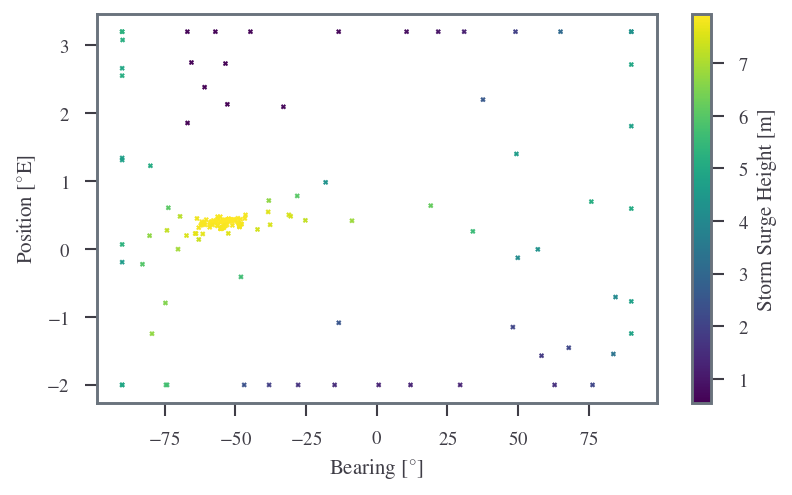

In [35]:
plot_defaults()
plt.scatter(ds_act["active_x"].isel(var=0).values, 
            ds_act["active_x"].isel(var=1).values, 
            s=5, 
            c=ds_act["active_y"].values)
plt.colorbar(label="Storm Surge Height [m]")
plt.xlabel("Bearing [$^{\circ}$]")
plt.ylabel("Position [$^{\circ}$E]")

In [37]:
ds_act["active_y"].max(dim="anum")

<xarray.DataArray 'active_y' ()>
array(7.94099995)

Text(0, 0.5, 'Position [$^{\\circ}$E]')

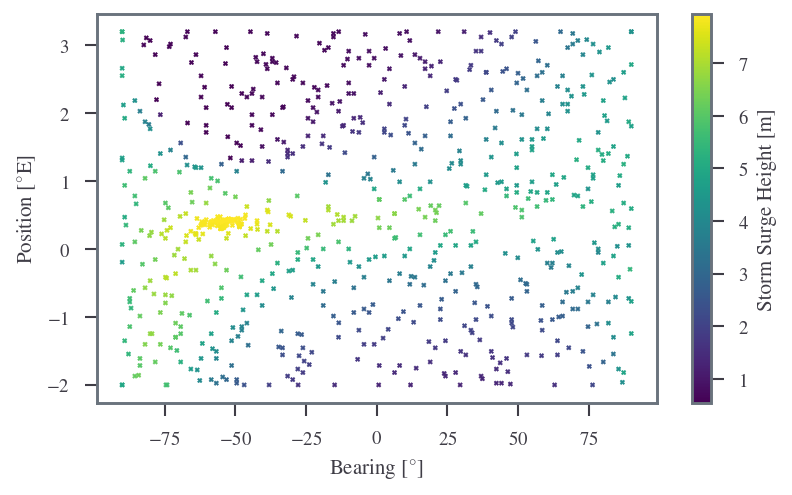

In [38]:
plot_defaults()
plt.scatter(ds_comb["init_x"].isel(var=0).values, ds_comb["init_x"].isel(var=1).values, s=5, c=ds_comb["init_y"].values)
plt.scatter(ds_act["active_x"].isel(var=0).values, 
            ds_act["active_x"].isel(var=1).values, 
            s=5, 
            c=ds_act["active_y"].values)
plt.colorbar(label="Storm Surge Height [m]")
plt.xlabel("Bearing [$^{\circ}$]")
plt.ylabel("Position [$^{\circ}$E]")

In [40]:
anum = np.argmax(ds_act["active_y"].values)
ds_act.isel(anum=anum)

<xarray.Dataset>
Dimensions:   (var: 2)
Coordinates:
  * var       (var) object 'x1' 'x2'
Data variables:
    active_x  (var) float64 -52.67 0.4198
    active_y  float64 7.941
Attributes:
    description:  Training Data

In [42]:
inum = np.argmax(ds_comb["init_y"].values)
ds_comb.isel(inum=inum)

<xarray.Dataset>
Dimensions:  (var: 2)
Coordinates:
  * var      (var) object 'x1' 'x2'
Data variables:
    init_x   (var) float32 -55.35 0.379
    init_y   float64 7.916
Attributes:
    description:  Training Data

## So current best guesses:

Latin hypercube -55.35 $^{\circ}$, 0.379 $^{\circ}$E --> 7.916 m

Active Learning -52.67 $^{\circ}$, 0.4198 $^{\circ}$E --> 7.941 m
